In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 2
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 2
DIS_N_CLASSES = 1
EPOCH = 100

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet34"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "sigmoid"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 3e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.canny2 import Canny

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [13]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [14]:
perceptual_ext = PerceptualLoss()

In [15]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)
    
    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    perceptual_l = 0
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

       ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        set_requires_grad(discriminator, True)
        dis_optimizer.zero_grad()
        
        *_, edge_y_pr = Canny(low_threshold=0, high_threshold=0.2).to(device)(y_pr.detach())
        *_, edge_y = Canny(low_threshold=0, high_threshold=0.2).to(device)(y)
        
        y_cls = discriminator(torch.cat((y, edge_y), dim=1))
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(torch.cat((y_pr.detach(), edge_y_pr), dim=1))
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        _dis = nn.BCELoss()(y_cls.float(), torch.zeros(y_cls.size(), dtype=torch.float, device=device)) + \
                                nn.BCELoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size(), dtype=torch.float, device=device))

        _dis.backward()
        dis_optimizer.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        set_requires_grad(discriminator, False)
        gen_optimizer.zero_grad()
        
        # main loss
        # Perceptual loss
        perceptual_loss = perceptual_ext(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())
        _ssim =SSIMLoss()(y_pr.float(), y.float(), data_range=1.0, size_average=True) # return (N,)
        
        # adversarial loss
        *_, edge_y_pr = Canny(low_threshold=0, high_threshold=0.2).to(device)(y_pr)
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = discriminator(torch.cat((y_pr, edge_y_pr), dim=1))
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        _gen = nn.BCELoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size(), dtype=torch.float, device=device))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())
        
        _loss = _gen + air_loss + bone_loss + perceptual_loss + _mae + _ssim
        _loss.backward()    
        gen_optimizer.step()

        dis_l += _dis.item()
        gen_l += _gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        mae_l += _mae.item()
        ssim_l += _ssim.item()
        perceptual_l += perceptual_loss.item()
        
    return  perceptual_l/(index+1), ssim_l/(index+1), mae_l/(index+1), air_l/(index+1), bone_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [16]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    cont_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

        *_, edge_y_pr = Canny(low_threshold=0, high_threshold=0.2).to(device)(y_pr)
        *_, edge_y = Canny(low_threshold=0, high_threshold=0.2).to(device)(y)
        
        y_cls = discriminator(torch.cat((y, edge_y), dim=1))
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(torch.cat((y_pr, edge_y_pr), dim=1))
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        acc = Accuracy()(y_cls, torch.zeros(y_cls.size(), device=y_cls.device))
        acc_ += [acc.item()]
        acc = Accuracy()(y_pr_cls, torch.ones(y_pr_cls.size(), device=y_pr_cls.device))
        acc_ += [acc.item()]
        
        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(acc_)/len(acc_)

In [47]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        *_, edge_x = Canny(low_threshold=0, high_threshold=0.2).to(device)(x)
        *_, edge_y = Canny(low_threshold=0, high_threshold=0.2).to(device)(y)
        *_, edge_y_pr = Canny(low_threshold=0, high_threshold=0.2).to(device)(y_pr)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [18]:
from codes.activation import Activation
import torchvision.models as models

In [19]:
class Model(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Model, self).__init__()
        
        encoder = models.resnet34()
        encoder.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.fc = nn.Linear(in_features=512, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Read Data

In [20]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [21]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [22]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [23]:
len(trainset), len(testset)

(1344, 191)

In [24]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f60737a15b0>,)

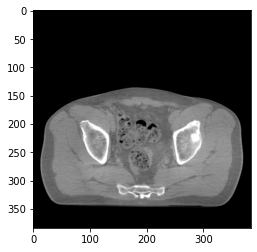

In [25]:
plt.imshow(x.squeeze(), 'gray'),

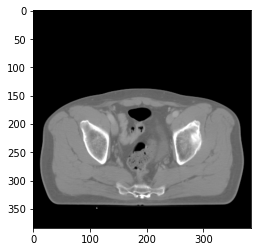

In [26]:
plt.imshow(y.squeeze(), 'gray')

In [27]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [28]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [29]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [30]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [31]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [32]:
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
replace_relu_to_leakyReLU(discriminator)

In [33]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): LeakyReLU(negative_slope=0.01)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, e

In [34]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [36]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_perceptual, loss_ssim, loss_mae, loss_air, loss_bone, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_cont_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_cont_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        wandb.log({
            "loss ssim": loss_ssim,
            "loss mae": loss_mae,
            "loss perceptual": loss_perceptual,
            "loss mask": loss_air,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "loss bone": loss_bone,
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test + score_cont_test >  max_score:
            max_score = score_bone_test +  score_air_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

672it [04:43,  2.37it/s]
672it [01:35,  7.05it/s]
96it [00:12,  7.77it/s]
672it [05:04,  2.21it/s]
672it [01:09,  9.72it/s]
96it [00:08, 10.93it/s]
672it [03:13,  3.48it/s]
672it [00:55, 12.15it/s]
96it [00:07, 12.99it/s]
672it [03:09,  3.55it/s]
672it [00:56, 11.97it/s]
96it [00:07, 12.79it/s]
672it [03:02,  3.68it/s]
672it [00:55, 12.10it/s]
96it [00:07, 12.92it/s]
672it [03:03,  3.67it/s]
672it [00:55, 12.01it/s]
96it [00:07, 12.43it/s]
672it [02:59,  3.74it/s]
672it [00:55, 12.10it/s]
96it [00:07, 12.07it/s]
672it [03:03,  3.66it/s]
672it [00:53, 12.63it/s]
96it [00:07, 12.95it/s]
672it [03:00,  3.72it/s]
672it [00:53, 12.50it/s]
96it [00:07, 13.19it/s]
672it [02:58,  3.77it/s]
672it [00:55, 12.16it/s]
96it [00:07, 13.05it/s]
672it [03:03,  3.66it/s]
672it [00:56, 11.93it/s]
96it [00:07, 12.01it/s]
672it [03:04,  3.64it/s]
672it [00:55, 12.11it/s]
96it [00:07, 12.85it/s]
672it [03:05,  3.61it/s]
672it [00:55, 12.10it/s]
96it [00:07, 12.49it/s]
672it [03:00,  3.73it/s]
672it [00:55,

In [37]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [38]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [39]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.9022481441497803
psnr score = 26.62489891052246
snr score = 16.687837600708008
mae error = 0.01543310098350048
air dice score = 0.9987993307745312
bone dice score = 0.9665155724526024
contour dice score = 0.4925462007522583


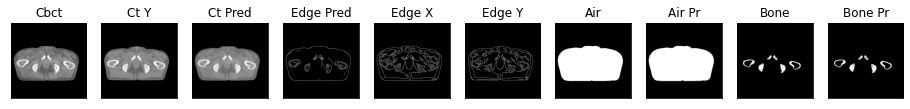

1it [00:00,  1.63it/s]

ssim score = 0.9034097194671631
psnr score = 26.562366485595703
snr score = 16.672842025756836
mae error = 0.01566816121339798
air dice score = 0.9989872073471725
bone dice score = 0.9716693302343212
contour dice score = 0.5541591644287109


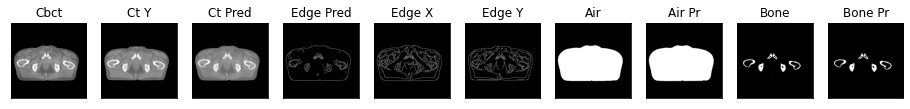

2it [00:01,  1.75it/s]

ssim score = 0.901259183883667
psnr score = 26.25693130493164
snr score = 16.53030014038086
mae error = 0.017084989696741104
air dice score = 0.9985634163140819
bone dice score = 0.9533898305090555
contour dice score = 0.5616766214370728


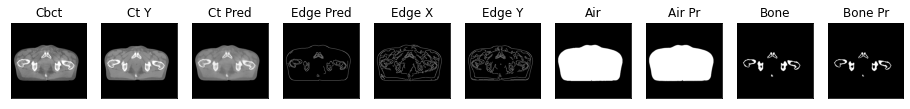

3it [00:21,  6.63s/it]

ssim score = 0.8985892534255981
psnr score = 26.204730987548828
snr score = 16.567352294921875
mae error = 0.017643921077251434
air dice score = 0.9988562413725115
bone dice score = 0.9308219178090088
contour dice score = 0.6470940709114075


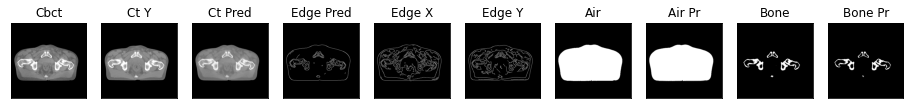

4it [00:22,  4.77s/it]

ssim score = 0.8981858491897583
psnr score = 26.289283752441406
snr score = 16.692209243774414
mae error = 0.017722034826874733
air dice score = 0.9984569122418311
bone dice score = 0.9040286859322503
contour dice score = 0.6714714765548706


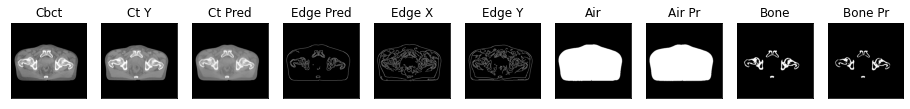

5it [00:22,  3.48s/it]

ssim score = 0.8937890529632568
psnr score = 25.96624183654785
snr score = 16.505701065063477
mae error = 0.019192250445485115
air dice score = 0.9984008899395135
bone dice score = 0.8572225839470076
contour dice score = 0.6795180439949036


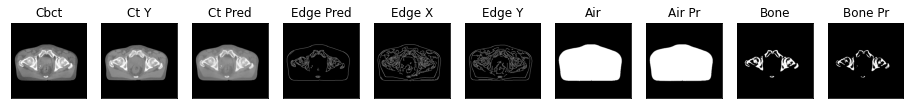

6it [00:23,  2.57s/it]

ssim score = 0.8909004330635071
psnr score = 25.683639526367188
snr score = 16.19904136657715
mae error = 0.019458558410406113
air dice score = 0.9985002699514103
bone dice score = 0.8672566371693163
contour dice score = 0.6920750141143799


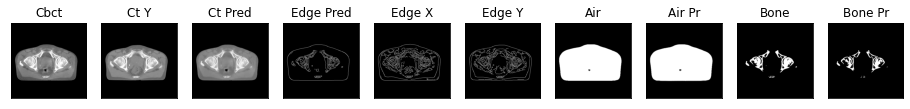

7it [00:23,  1.94s/it]

ssim score = 0.8939242959022522
psnr score = 26.342485427856445
snr score = 16.67234992980957
mae error = 0.017701517790555954
air dice score = 0.9987227580380772
bone dice score = 0.9080611666989988
contour dice score = 0.6618093252182007


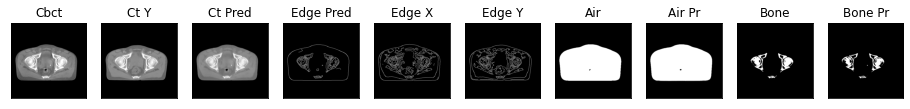

8it [00:24,  1.49s/it]

ssim score = 0.8981065154075623
psnr score = 26.946548461914062
snr score = 17.181859970092773
mae error = 0.016581282019615173
air dice score = 0.9991201011378011
bone dice score = 0.9409409409415321
contour dice score = 0.630103588104248


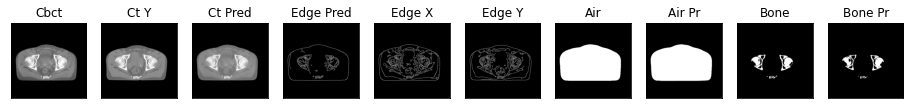

9it [00:24,  1.20s/it]

ssim score = 0.9015698432922363
psnr score = 26.881797790527344
snr score = 17.101825714111328
mae error = 0.01659942790865898
air dice score = 0.9986661371944093
bone dice score = 0.9373690825310288
contour dice score = 0.5827733874320984


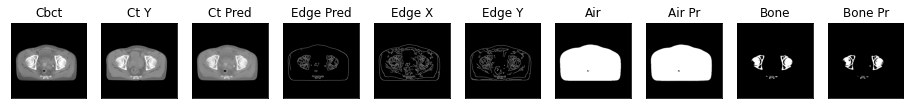

10it [00:25,  1.02it/s]

ssim score = 0.9070266485214233
psnr score = 27.268037796020508
snr score = 17.520334243774414
mae error = 0.01637054793536663
air dice score = 0.9984848484848501
bone dice score = 0.9545006030045554
contour dice score = 0.5737003087997437


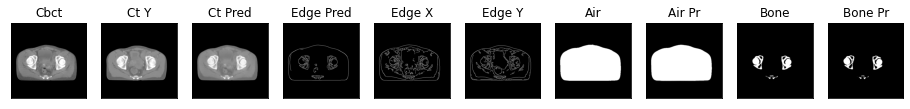

11it [00:25,  1.21it/s]

ssim score = 0.9059211611747742
psnr score = 26.076004028320312
snr score = 16.35201072692871
mae error = 0.017795588821172714
air dice score = 0.9986437940637535
bone dice score = 0.9487661834685319
contour dice score = 0.5588235259056091


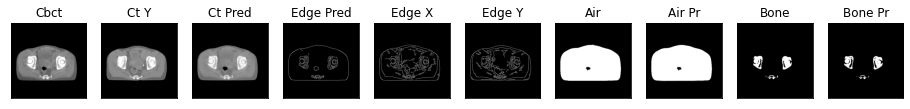

12it [00:26,  1.39it/s]

ssim score = 0.909336507320404
psnr score = 25.299427032470703
snr score = 15.543513298034668
mae error = 0.018455402925610542
air dice score = 0.9984503591397416
bone dice score = 0.9590231302106489
contour dice score = 0.5199264287948608


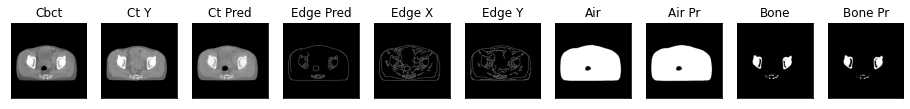

13it [00:26,  1.36it/s]

ssim score = 0.9075782299041748
psnr score = 25.271455764770508
snr score = 15.373583793640137
mae error = 0.017393507063388824
air dice score = 0.9982784660393119
bone dice score = 0.9558842118574657
contour dice score = 0.5571340322494507


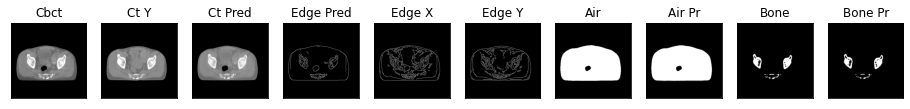

14it [00:27,  1.54it/s]

ssim score = 0.9040416479110718
psnr score = 25.14409637451172
snr score = 15.160562515258789
mae error = 0.017474422231316566
air dice score = 0.9977368113478216
bone dice score = 0.9551324723744491
contour dice score = 0.6040765643119812


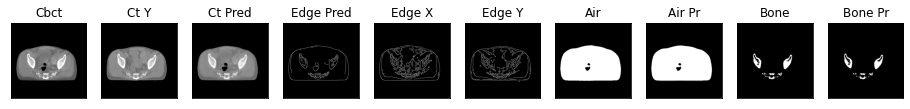

15it [00:27,  1.68it/s]

ssim score = 0.8968648314476013
psnr score = 24.854394912719727
snr score = 14.894346237182617
mae error = 0.018642380833625793
air dice score = 0.9985360901853946
bone dice score = 0.9506761107540158
contour dice score = 0.6566416025161743


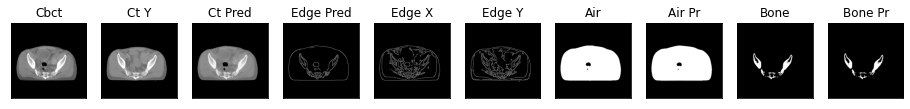

16it [00:28,  1.84it/s]

ssim score = 0.8922582864761353
psnr score = 23.940532684326172
snr score = 13.977941513061523
mae error = 0.020375771448016167
air dice score = 0.9983353510895902
bone dice score = 0.9419879295486884
contour dice score = 0.6415094137191772


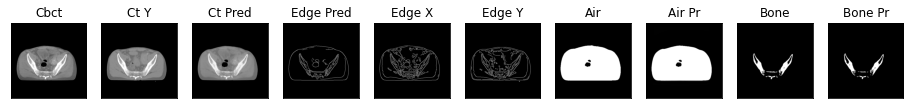

17it [00:28,  1.86it/s]

ssim score = 0.8842883110046387
psnr score = 23.30035400390625
snr score = 13.236001968383789
mae error = 0.021344780921936035
air dice score = 0.9974212723180168
bone dice score = 0.9327007117001785
contour dice score = 0.5921787619590759


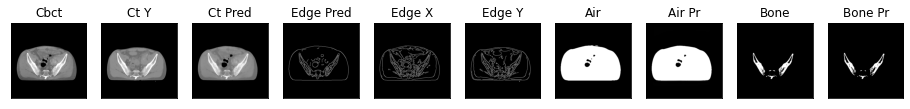

18it [00:29,  1.95it/s]

ssim score = 0.8812814354896545
psnr score = 22.980451583862305
snr score = 12.86541748046875
mae error = 0.0220011156052351
air dice score = 0.9971936389148768
bone dice score = 0.9316113161140023
contour dice score = 0.5810983180999756


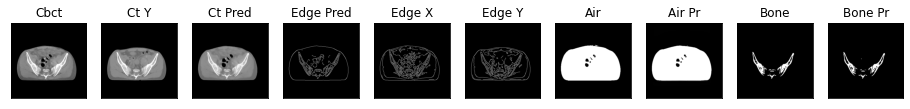

19it [00:29,  2.04it/s]

ssim score = 0.8850477337837219
psnr score = 23.102924346923828
snr score = 12.975579261779785
mae error = 0.021997833624482155
air dice score = 0.9972992716888437
bone dice score = 0.9240669240679014
contour dice score = 0.5218492746353149


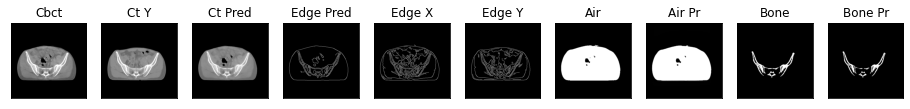

20it [00:30,  2.09it/s]

ssim score = 0.8826804161071777
psnr score = 23.051128387451172
snr score = 12.858936309814453
mae error = 0.021949876099824905
air dice score = 0.9979903536977515
bone dice score = 0.920005584253525
contour dice score = 0.48880359530448914


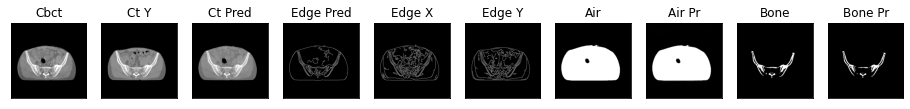

21it [00:30,  2.14it/s]

ssim score = 0.8815142512321472
psnr score = 23.12157440185547
snr score = 12.869950294494629
mae error = 0.021317023783922195
air dice score = 0.9968308909466906
bone dice score = 0.9291080453499644
contour dice score = 0.5093008279800415


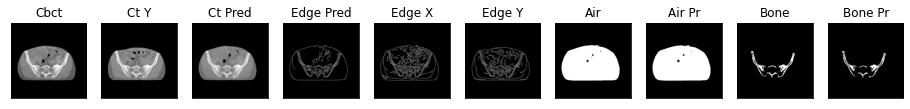

22it [00:30,  2.16it/s]

ssim score = 0.8862501978874207
psnr score = 23.33814239501953
snr score = 13.053092956542969
mae error = 0.02096765860915184
air dice score = 0.9970150608904913
bone dice score = 0.9226583754382348
contour dice score = 0.6139896512031555


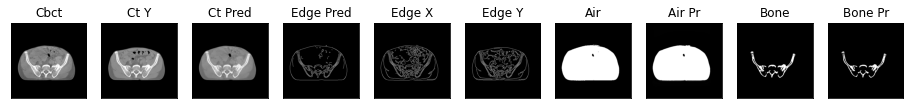

23it [00:31,  1.84it/s]

ssim score = 0.8864988088607788
psnr score = 23.334444046020508
snr score = 13.00083065032959
mae error = 0.02105371654033661
air dice score = 0.9964586556644359
bone dice score = 0.9113860136340396
contour dice score = 0.5895571708679199


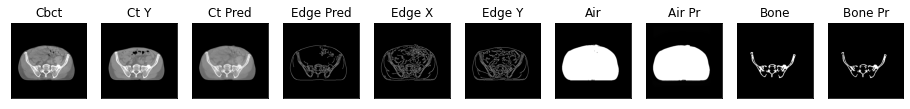

24it [00:32,  1.95it/s]

ssim score = 0.8844597935676575
psnr score = 23.154630661010742
snr score = 12.724018096923828
mae error = 0.021253246814012527
air dice score = 0.9974176437744307
bone dice score = 0.9095770539631796
contour dice score = 0.4909456670284271


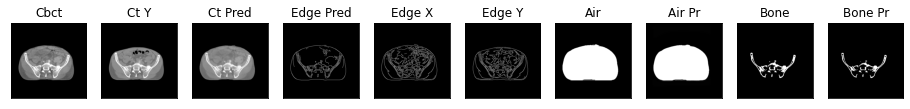

25it [00:32,  2.02it/s]

ssim score = 0.886779248714447
psnr score = 23.24986457824707
snr score = 12.736515998840332
mae error = 0.0207582525908947
air dice score = 0.9970017846519964
bone dice score = 0.9006301502678061
contour dice score = 0.5386703014373779


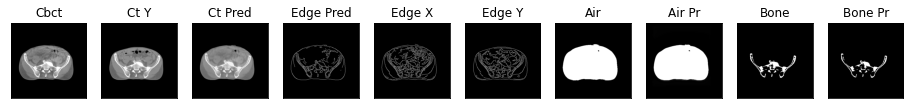

26it [00:32,  2.10it/s]

ssim score = 0.884663462638855
psnr score = 23.35686683654785
snr score = 12.75233268737793
mae error = 0.02083100751042366
air dice score = 0.9970131131617326
bone dice score = 0.9013849092657427
contour dice score = 0.6416666507720947


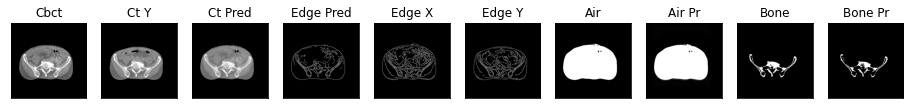

27it [00:33,  2.13it/s]

ssim score = 0.8855690360069275
psnr score = 23.25619125366211
snr score = 12.610550880432129
mae error = 0.0208271574229002
air dice score = 0.9965771134477621
bone dice score = 0.9070371625448205
contour dice score = 0.6320952773094177


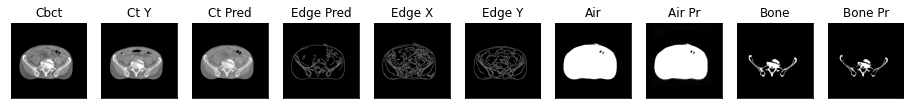

28it [00:33,  2.14it/s]

ssim score = 0.8726096153259277
psnr score = 23.885116577148438
snr score = 15.25727367401123
mae error = 0.02295762114226818
air dice score = 0.9983373611634774
bone dice score = 0.9343239227359785
contour dice score = 0.574089765548706


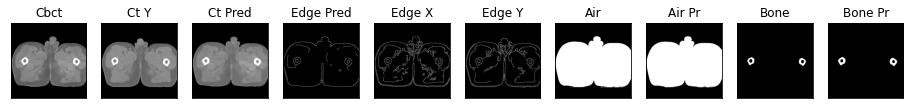

29it [00:34,  2.06it/s]

ssim score = 0.8781422972679138
psnr score = 24.446840286254883
snr score = 15.858254432678223
mae error = 0.021828357130289078
air dice score = 0.9979380434051054
bone dice score = 0.942393736019508
contour dice score = 0.5430853366851807


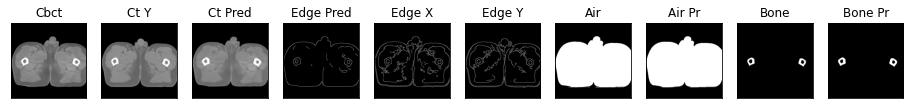

30it [00:34,  2.06it/s]

ssim score = 0.8869081735610962
psnr score = 25.09351921081543
snr score = 16.59238624572754
mae error = 0.0213009063154459
air dice score = 0.9979516541760131
bone dice score = 0.9476718403559274
contour dice score = 0.5172719359397888


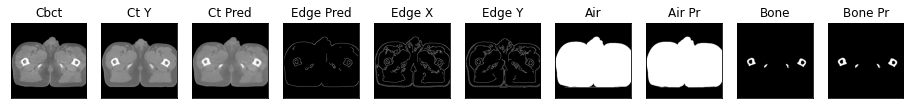

31it [00:35,  2.11it/s]

ssim score = 0.8925248980522156
psnr score = 25.50886344909668
snr score = 17.170284271240234
mae error = 0.022170986980199814
air dice score = 0.9989791172082184
bone dice score = 0.9695463020514365
contour dice score = 0.5582034587860107


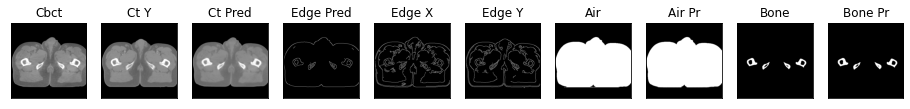

32it [00:35,  2.13it/s]

ssim score = 0.894546389579773
psnr score = 25.801464080810547
snr score = 17.591026306152344
mae error = 0.022307300940155983
air dice score = 0.9990378602010878
bone dice score = 0.9683122535024029
contour dice score = 0.5171455144882202


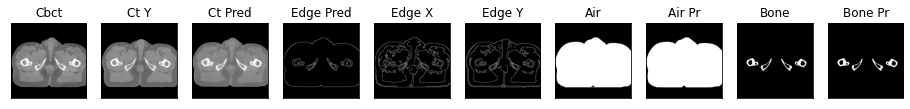

33it [00:36,  1.80it/s]

ssim score = 0.8965596556663513
psnr score = 26.208372116088867
snr score = 18.101173400878906
mae error = 0.02235674485564232
air dice score = 0.9991494561311041
bone dice score = 0.9662705557560163
contour dice score = 0.5612244606018066


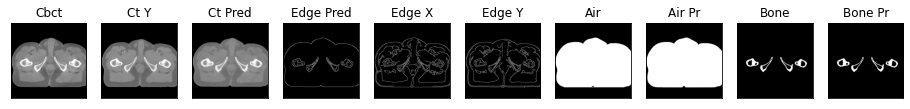

34it [00:37,  1.89it/s]

ssim score = 0.8979951739311218
psnr score = 26.531694412231445
snr score = 18.491596221923828
mae error = 0.022725820541381836
air dice score = 0.9990812223322639
bone dice score = 0.9606070751036647
contour dice score = 0.5202043652534485


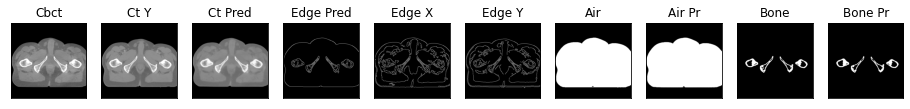

35it [00:37,  1.94it/s]

ssim score = 0.8970110416412354
psnr score = 26.669790267944336
snr score = 18.61980628967285
mae error = 0.02232293412089348
air dice score = 0.9991078119981448
bone dice score = 0.9625850340140032
contour dice score = 0.5457909107208252


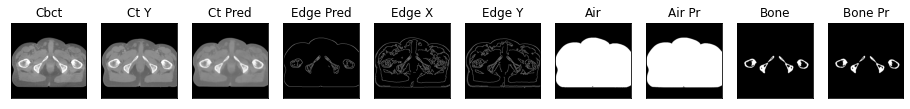

36it [00:37,  1.99it/s]

ssim score = 0.9006467461585999
psnr score = 26.87931251525879
snr score = 18.815662384033203
mae error = 0.021780099719762802
air dice score = 0.9992164498053001
bone dice score = 0.9672803787483716
contour dice score = 0.53721684217453


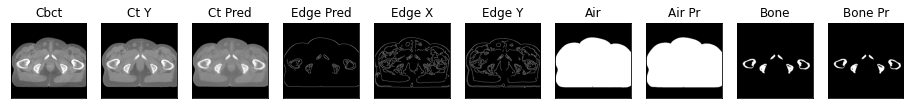

37it [00:38,  2.02it/s]

ssim score = 0.9038013815879822
psnr score = 27.077659606933594
snr score = 19.026010513305664
mae error = 0.021915292367339134
air dice score = 0.999122536580739
bone dice score = 0.9650597080941502
contour dice score = 0.5563282370567322


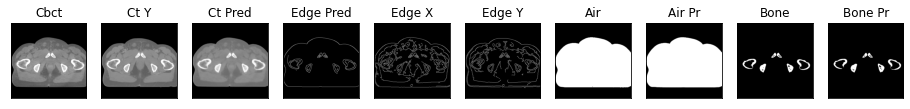

38it [00:38,  2.05it/s]

ssim score = 0.90457683801651
psnr score = 27.073116302490234
snr score = 19.060550689697266
mae error = 0.02189849130809307
air dice score = 0.999117063198128
bone dice score = 0.9626157539732181
contour dice score = 0.5595903396606445


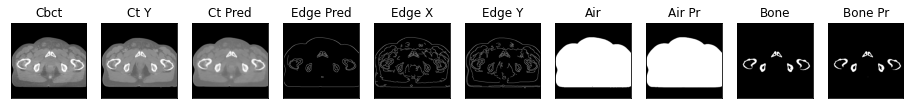

39it [00:39,  2.07it/s]

ssim score = 0.9039276242256165
psnr score = 26.760862350463867
snr score = 18.889583587646484
mae error = 0.023302147164940834
air dice score = 0.9991998530100349
bone dice score = 0.9390096618363626
contour dice score = 0.5676937699317932


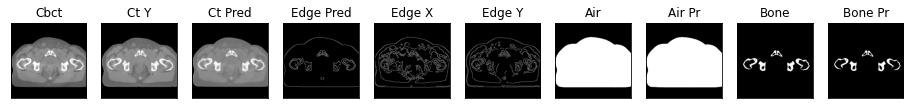

40it [00:39,  2.12it/s]

ssim score = 0.903398334980011
psnr score = 26.652587890625
snr score = 18.87599754333496
mae error = 0.02424744702875614
air dice score = 0.9992937811196244
bone dice score = 0.9051835296148442
contour dice score = 0.529026210308075


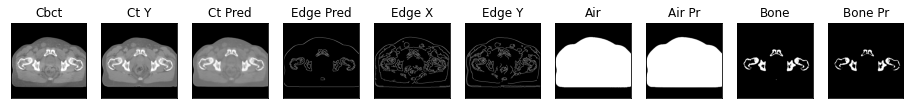

41it [00:40,  2.16it/s]

ssim score = 0.8935302495956421
psnr score = 26.009740829467773
snr score = 18.19910430908203
mae error = 0.02467496693134308
air dice score = 0.9990709861838977
bone dice score = 0.8735671514125444
contour dice score = 0.5422138571739197


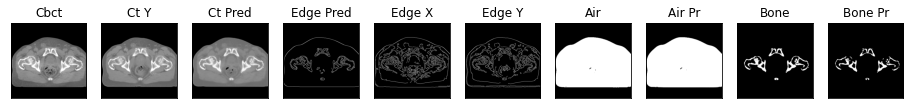

42it [00:40,  2.15it/s]

ssim score = 0.8905629515647888
psnr score = 25.031816482543945
snr score = 17.293365478515625
mae error = 0.02620982937514782
air dice score = 0.998759862686246
bone dice score = 0.809173186072947
contour dice score = 0.5266132950782776


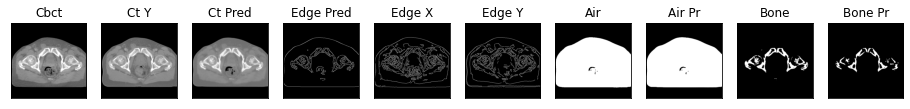

43it [00:41,  1.75it/s]

ssim score = 0.89005446434021
psnr score = 25.25395965576172
snr score = 17.37941551208496
mae error = 0.025062233209609985
air dice score = 0.9990560876335461
bone dice score = 0.8629605076251259
contour dice score = 0.5301886796951294


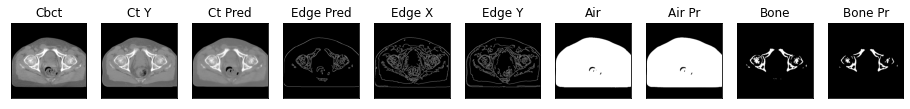

44it [00:42,  1.86it/s]

ssim score = 0.8945415019989014
psnr score = 25.684616088867188
snr score = 17.63150978088379
mae error = 0.02285468392074108
air dice score = 0.999155843372768
bone dice score = 0.9114740875185373
contour dice score = 0.5383886098861694


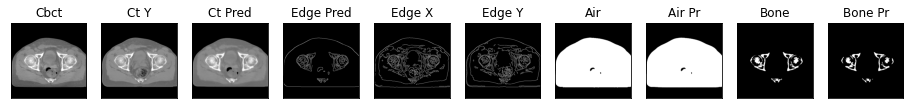

45it [00:42,  1.94it/s]

ssim score = 0.8935704231262207
psnr score = 26.028095245361328
snr score = 17.8843994140625
mae error = 0.02247280813753605
air dice score = 0.9992392039416486
bone dice score = 0.9147562875593729
contour dice score = 0.5304182767868042


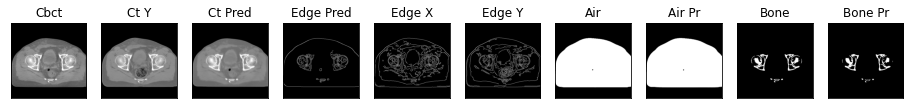

46it [00:42,  2.00it/s]

ssim score = 0.8935991525650024
psnr score = 25.953006744384766
snr score = 17.825000762939453
mae error = 0.02262805961072445
air dice score = 0.9992659860355364
bone dice score = 0.9223382045937125
contour dice score = 0.5515267252922058


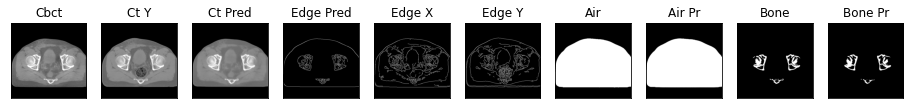

47it [00:43,  2.02it/s]

ssim score = 0.8822000622749329
psnr score = 25.695850372314453
snr score = 17.577880859375
mae error = 0.02366829849779606
air dice score = 0.999213313899951
bone dice score = 0.9194367276566775
contour dice score = 0.532951295375824


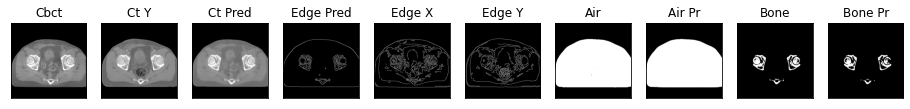

48it [00:43,  2.06it/s]

ssim score = 0.8900012969970703
psnr score = 26.009403228759766
snr score = 17.953022003173828
mae error = 0.02347435988485813
air dice score = 0.9990760513739917
bone dice score = 0.9129443071667654
contour dice score = 0.5343511700630188


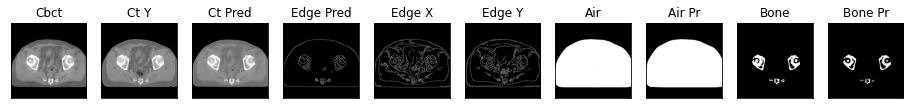

49it [00:44,  2.10it/s]

ssim score = 0.8919727206230164
psnr score = 26.210241317749023
snr score = 18.22394371032715
mae error = 0.024254104122519493
air dice score = 0.9988715533313716
bone dice score = 0.937801657408817
contour dice score = 0.5243088603019714


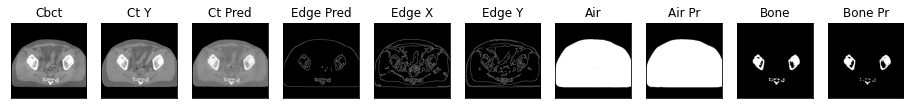

50it [00:44,  2.20it/s]

ssim score = 0.8965047001838684
psnr score = 26.213300704956055
snr score = 18.107894897460938
mae error = 0.023094452917575836
air dice score = 0.9987486198012522
bone dice score = 0.9306428716291762
contour dice score = 0.5019047856330872


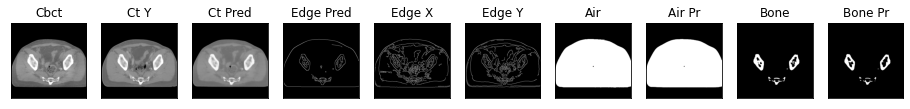

51it [00:45,  2.19it/s]

ssim score = 0.8895512819290161
psnr score = 25.363441467285156
snr score = 17.339664459228516
mae error = 0.0253900196403265
air dice score = 0.9987005185666482
bone dice score = 0.9216384683889436
contour dice score = 0.4863571226596832


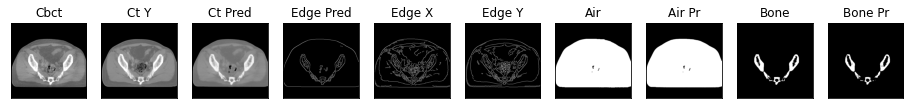

52it [00:45,  2.28it/s]

ssim score = 0.8888958692550659
psnr score = 25.37531852722168
snr score = 17.431690216064453
mae error = 0.026109304279088974
air dice score = 0.9985014832257877
bone dice score = 0.8868882733157365
contour dice score = 0.469005286693573


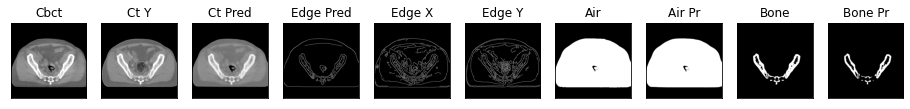

53it [00:47,  1.32it/s]

ssim score = 0.8732115626335144
psnr score = 24.817371368408203
snr score = 16.895299911499023
mae error = 0.027513574808835983
air dice score = 0.9984561403508782
bone dice score = 0.8757986598108478
contour dice score = 0.44090691208839417


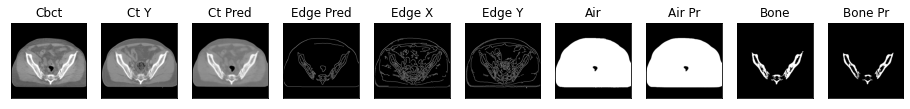

54it [00:47,  1.42it/s]

ssim score = 0.8768247961997986
psnr score = 25.529157638549805
snr score = 17.619626998901367
mae error = 0.026719288900494576
air dice score = 0.9986444124375167
bone dice score = 0.8847904567580852
contour dice score = 0.42829644680023193


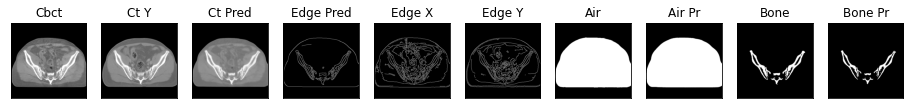

55it [00:48,  1.60it/s]

ssim score = 0.813106119632721
psnr score = 20.962955474853516
snr score = 10.843164443969727
mae error = 0.032337889075279236
air dice score = 0.9984102884701274
bone dice score = 0.9219143576845865
contour dice score = 0.6368653178215027


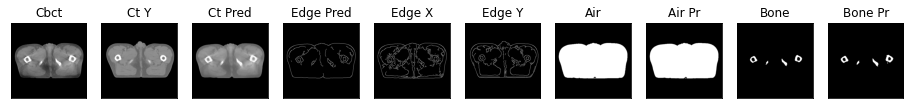

56it [00:48,  1.74it/s]

ssim score = 0.803831934928894
psnr score = 20.723703384399414
snr score = 10.816889762878418
mae error = 0.033637020736932755
air dice score = 0.998615032227136
bone dice score = 0.9120988638646184
contour dice score = 0.5824176073074341


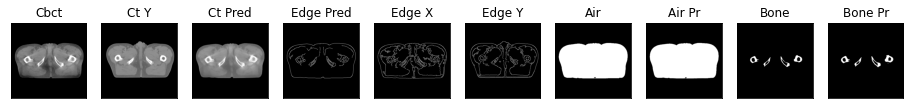

57it [00:49,  1.87it/s]

ssim score = 0.8009067177772522
psnr score = 20.758392333984375
snr score = 10.982721328735352
mae error = 0.03385332226753235
air dice score = 0.9986402006145599
bone dice score = 0.8948727406880326
contour dice score = 0.6040415167808533


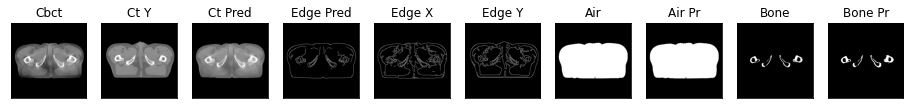

58it [00:49,  1.97it/s]

ssim score = 0.8038102388381958
psnr score = 21.044490814208984
snr score = 11.33922004699707
mae error = 0.032899755984544754
air dice score = 0.9984981424393342
bone dice score = 0.877383242961739
contour dice score = 0.5340599417686462


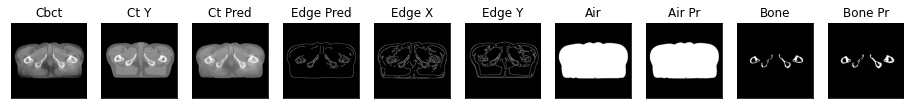

59it [00:50,  1.98it/s]

ssim score = 0.8046796917915344
psnr score = 21.145503997802734
snr score = 11.487800598144531
mae error = 0.032597530633211136
air dice score = 0.997829131652663
bone dice score = 0.8907159986315396
contour dice score = 0.5915032625198364


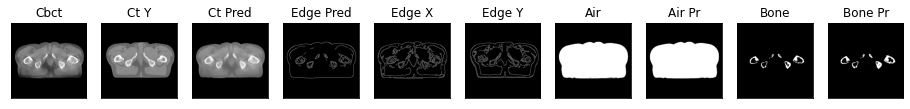

60it [00:50,  2.01it/s]

ssim score = 0.8044490218162537
psnr score = 21.30436134338379
snr score = 11.652274131774902
mae error = 0.03199698030948639
air dice score = 0.9979242617174572
bone dice score = 0.9144905273952126
contour dice score = 0.5989528894424438


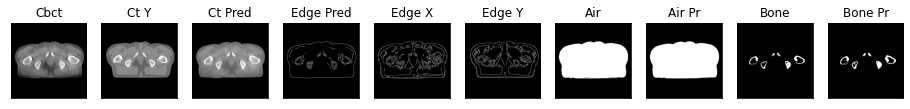

61it [00:50,  2.06it/s]

ssim score = 0.8057507276535034
psnr score = 21.341678619384766
snr score = 11.683087348937988
mae error = 0.03163742646574974
air dice score = 0.9978705096000923
bone dice score = 0.9056994818669136
contour dice score = 0.6177241802215576


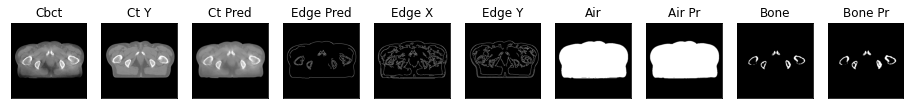

62it [00:51,  2.11it/s]

ssim score = 0.806381344795227
psnr score = 21.212223052978516
snr score = 11.567741394042969
mae error = 0.031971536576747894
air dice score = 0.9981117039706204
bone dice score = 0.9219394773053312
contour dice score = 0.5798941850662231


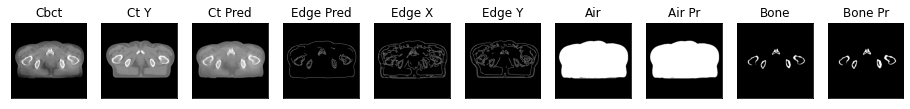

63it [00:52,  1.81it/s]

ssim score = 0.8050292730331421
psnr score = 21.09777069091797
snr score = 11.511298179626465
mae error = 0.03300866484642029
air dice score = 0.9981908677775388
bone dice score = 0.923100584436741
contour dice score = 0.584664523601532


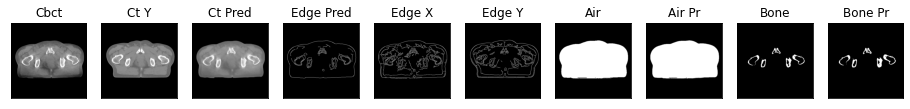

64it [00:52,  1.93it/s]

ssim score = 0.7985812425613403
psnr score = 20.949880599975586
snr score = 11.461967468261719
mae error = 0.03448321297764778
air dice score = 0.9976092041325402
bone dice score = 0.9136618301980511
contour dice score = 0.5874934196472168


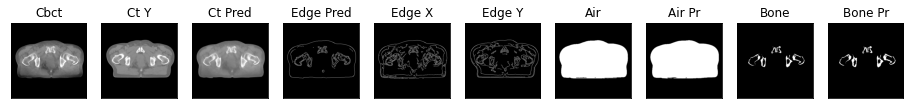

65it [00:53,  1.95it/s]

ssim score = 0.7891115546226501
psnr score = 20.803760528564453
snr score = 11.351675987243652
mae error = 0.03601846098899841
air dice score = 0.9972940365391267
bone dice score = 0.9180925666210646
contour dice score = 0.5499463081359863


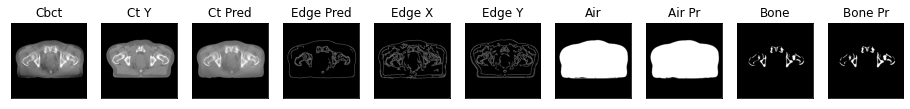

66it [00:53,  1.95it/s]

ssim score = 0.7791416645050049
psnr score = 20.69431495666504
snr score = 11.274938583374023
mae error = 0.036451589316129684
air dice score = 0.9974595465075246
bone dice score = 0.9103219213092703
contour dice score = 0.6177729964256287


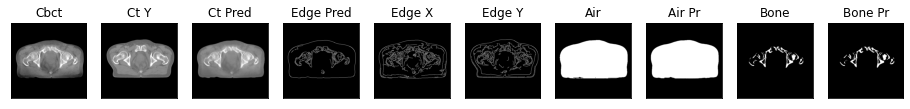

67it [00:54,  1.97it/s]

ssim score = 0.7806699872016907
psnr score = 20.791933059692383
snr score = 11.489371299743652
mae error = 0.03616250306367874
air dice score = 0.9977533506064251
bone dice score = 0.9126142595988711
contour dice score = 0.6758038997650146


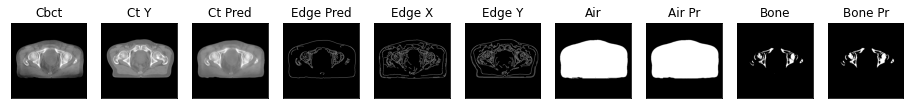

68it [00:54,  2.06it/s]

ssim score = 0.7829998731613159
psnr score = 20.78476905822754
snr score = 11.466218948364258
mae error = 0.03594670072197914
air dice score = 0.9982189718218987
bone dice score = 0.8828155214659944
contour dice score = 0.6786296963691711


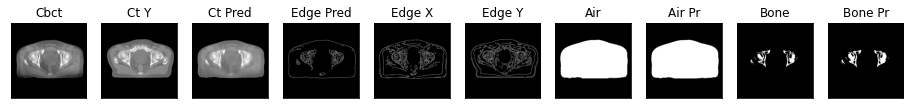

69it [00:54,  2.13it/s]

ssim score = 0.7976168394088745
psnr score = 21.26862335205078
snr score = 11.750909805297852
mae error = 0.03311656787991524
air dice score = 0.9983746549366646
bone dice score = 0.8829845814994083
contour dice score = 0.6856223344802856


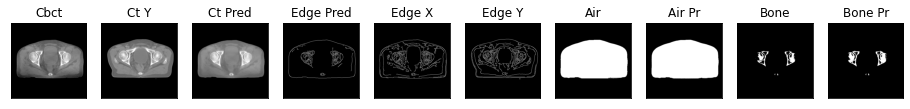

70it [00:55,  2.15it/s]

ssim score = 0.8160063028335571
psnr score = 21.954299926757812
snr score = 12.266196250915527
mae error = 0.03022189624607563
air dice score = 0.9982398447628957
bone dice score = 0.9132993330729267
contour dice score = 0.6741935610771179


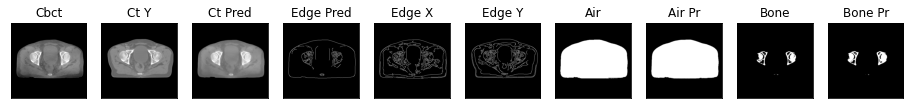

71it [00:55,  2.16it/s]

ssim score = 0.8238242864608765
psnr score = 22.39270782470703
snr score = 12.718770980834961
mae error = 0.0287423525005579
air dice score = 0.9979694126718948
bone dice score = 0.9372813593211234
contour dice score = 0.6865990161895752


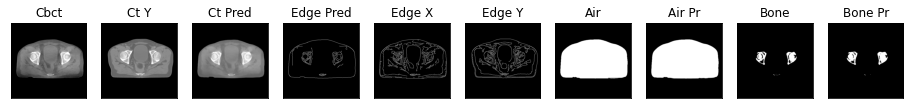

72it [00:56,  2.11it/s]

ssim score = 0.8287171125411987
psnr score = 22.683502197265625
snr score = 13.091394424438477
mae error = 0.027982473373413086
air dice score = 0.9982907443808237
bone dice score = 0.9585337319646623
contour dice score = 0.6710026860237122


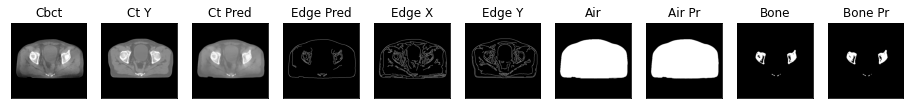

73it [00:57,  1.79it/s]

ssim score = 0.8272819519042969
psnr score = 22.683513641357422
snr score = 13.183576583862305
mae error = 0.028632082045078278
air dice score = 0.9981083199836411
bone dice score = 0.9235983618143822
contour dice score = 0.6714364290237427


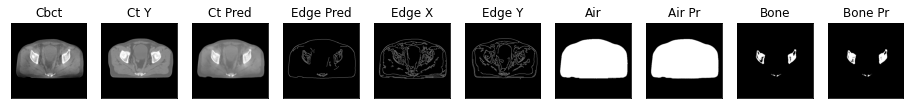

74it [00:57,  1.86it/s]

ssim score = 0.822910726070404
psnr score = 22.964664459228516
snr score = 13.401302337646484
mae error = 0.02776232734322548
air dice score = 0.9976999397401206
bone dice score = 0.9416391379590744
contour dice score = 0.7109919786453247


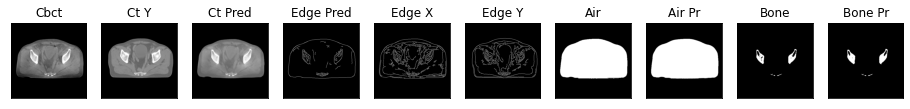

75it [00:58,  1.95it/s]

ssim score = 0.8273680210113525
psnr score = 23.101160049438477
snr score = 13.501405715942383
mae error = 0.026833735406398773
air dice score = 0.9977781923644462
bone dice score = 0.937732656515436
contour dice score = 0.6627597212791443


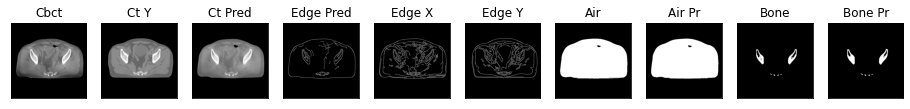

76it [00:58,  2.00it/s]

ssim score = 0.8247436285018921
psnr score = 22.86849021911621
snr score = 13.306482315063477
mae error = 0.02814001776278019
air dice score = 0.9974724771420354
bone dice score = 0.9252307692319195
contour dice score = 0.6482758522033691


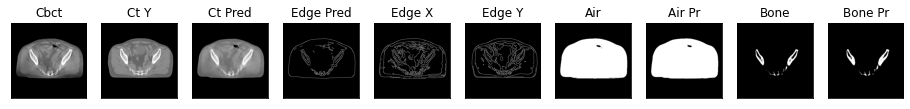

77it [00:58,  2.05it/s]

ssim score = 0.8225221037864685
psnr score = 22.903587341308594
snr score = 13.472084045410156
mae error = 0.02844141237437725
air dice score = 0.9975974395327337
bone dice score = 0.9358149719455889
contour dice score = 0.7068873643875122


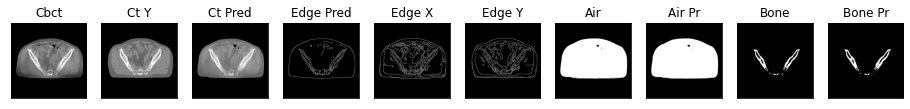

78it [00:59,  2.12it/s]

ssim score = 0.8243589997291565
psnr score = 22.731643676757812
snr score = 13.317888259887695
mae error = 0.02905946969985962
air dice score = 0.9975710986304426
bone dice score = 0.922556943425091
contour dice score = 0.6509130001068115


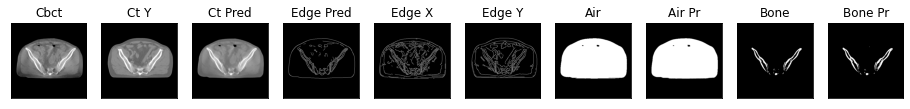

79it [00:59,  2.15it/s]

ssim score = 0.8281749486923218
psnr score = 23.204448699951172
snr score = 13.77942180633545
mae error = 0.0279547069221735
air dice score = 0.9975352172945607
bone dice score = 0.921850079746063
contour dice score = 0.6576673984527588


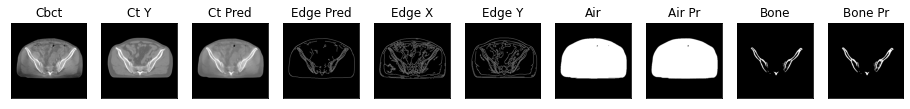

80it [01:00,  2.15it/s]

ssim score = 0.8316026926040649
psnr score = 23.350330352783203
snr score = 13.924565315246582
mae error = 0.027276480570435524
air dice score = 0.9975861802376044
bone dice score = 0.9189354542685999
contour dice score = 0.6742919683456421


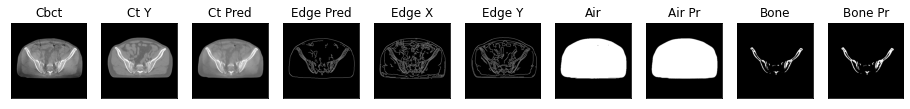

81it [01:00,  2.13it/s]

ssim score = 0.8788823485374451
psnr score = 24.065629959106445
snr score = 14.499763488769531
mae error = 0.020208971574902534
air dice score = 0.9977224221960328
bone dice score = 0.8589487691331021
contour dice score = 0.5413135886192322


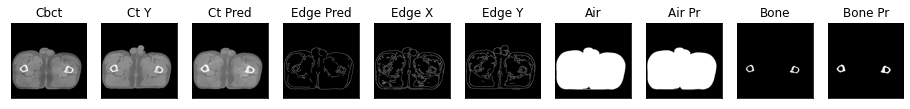

82it [01:01,  2.10it/s]

ssim score = 0.8797411322593689
psnr score = 24.399595260620117
snr score = 14.898119926452637
mae error = 0.01982773467898369
air dice score = 0.9979757725274394
bone dice score = 0.8538508186824181
contour dice score = 0.48560962080955505


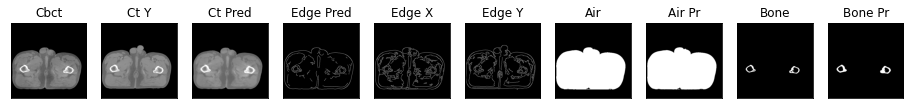

83it [01:02,  1.77it/s]

ssim score = 0.8884948492050171
psnr score = 26.071914672851562
snr score = 16.709653854370117
mae error = 0.018044808879494667
air dice score = 0.9985380459851002
bone dice score = 0.8954859699085912
contour dice score = 0.5650632977485657


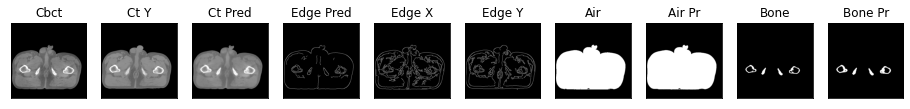

84it [01:02,  1.85it/s]

ssim score = 0.8898659348487854
psnr score = 26.138813018798828
snr score = 16.898042678833008
mae error = 0.018315399065613747
air dice score = 0.9988563426304128
bone dice score = 0.8644356211029602
contour dice score = 0.572601318359375


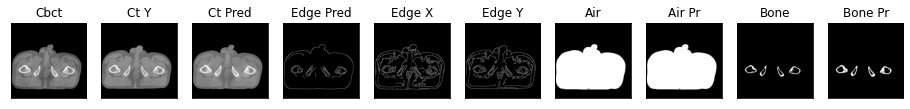

85it [01:03,  1.87it/s]

ssim score = 0.8861402869224548
psnr score = 25.955169677734375
snr score = 16.73857307434082
mae error = 0.01858135499060154
air dice score = 0.998680513513095
bone dice score = 0.8515880654504026
contour dice score = 0.5806117057800293


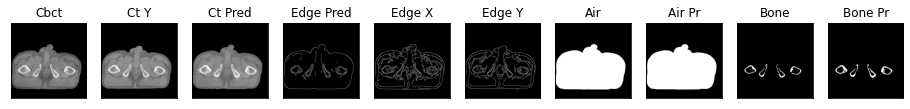

86it [01:03,  1.94it/s]

ssim score = 0.8863565325737
psnr score = 25.764366149902344
snr score = 16.543373107910156
mae error = 0.018814748153090477
air dice score = 0.9984254411479555
bone dice score = 0.8602797945836678
contour dice score = 0.5730689167976379


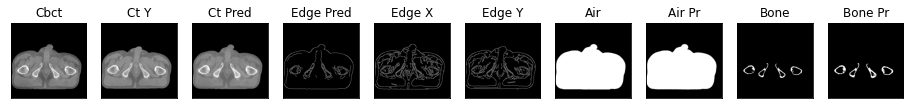

87it [01:04,  1.91it/s]

ssim score = 0.8857945799827576
psnr score = 25.248836517333984
snr score = 16.03409767150879
mae error = 0.019599994644522667
air dice score = 0.9979761950916931
bone dice score = 0.8734908136505076
contour dice score = 0.5352261066436768


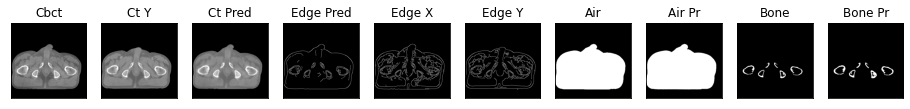

88it [01:04,  1.96it/s]

ssim score = 0.883216142654419
psnr score = 24.981830596923828
snr score = 15.74553394317627
mae error = 0.01968836598098278
air dice score = 0.9982229189138867
bone dice score = 0.8879035118856349
contour dice score = 0.5581884980201721


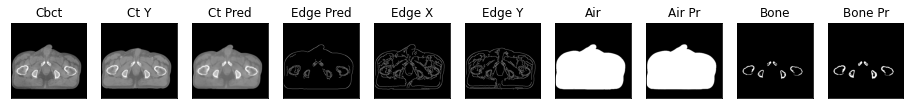

89it [01:05,  1.96it/s]

ssim score = 0.8839111924171448
psnr score = 25.063629150390625
snr score = 15.844244003295898
mae error = 0.019656838849186897
air dice score = 0.998054747194947
bone dice score = 0.9188724647659183
contour dice score = 0.5391949415206909


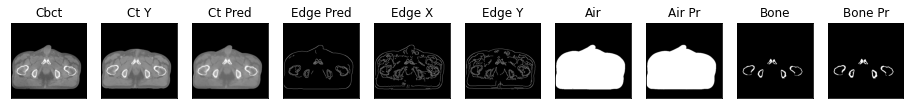

90it [01:05,  2.04it/s]

ssim score = 0.885673999786377
psnr score = 25.40410614013672
snr score = 16.253314971923828
mae error = 0.01935669779777527
air dice score = 0.998360271726401
bone dice score = 0.9167574295951959
contour dice score = 0.5958355665206909


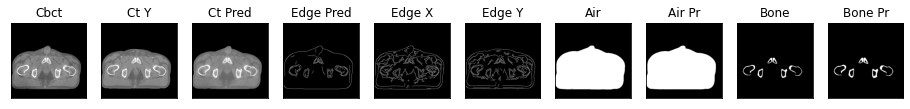

91it [01:06,  1.99it/s]

ssim score = 0.886804461479187
psnr score = 25.80134391784668
snr score = 16.73191261291504
mae error = 0.01943853683769703
air dice score = 0.9985654372280809
bone dice score = 0.9283236994230011
contour dice score = 0.5878559947013855


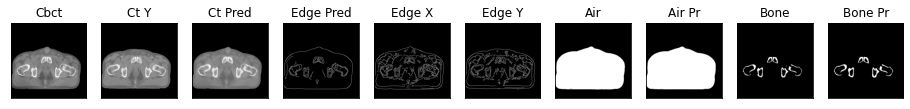

92it [01:06,  1.97it/s]

ssim score = 0.8894169926643372
psnr score = 26.200199127197266
snr score = 17.18147087097168
mae error = 0.019222529605031013
air dice score = 0.998842802150657
bone dice score = 0.9242906574404942
contour dice score = 0.6164604425430298


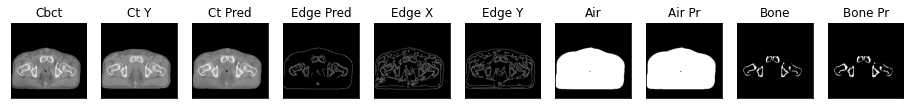

93it [01:07,  1.68it/s]

ssim score = 0.8927130699157715
psnr score = 26.640174865722656
snr score = 17.737714767456055
mae error = 0.01920471526682377
air dice score = 0.9991237556936151
bone dice score = 0.9191432396262498
contour dice score = 0.58772873878479


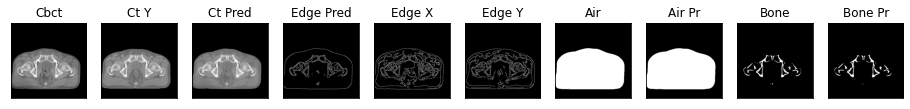

94it [01:07,  1.77it/s]

ssim score = 0.8919328451156616
psnr score = 26.09557342529297
snr score = 17.154876708984375
mae error = 0.01950615458190441
air dice score = 0.9990160135853616
bone dice score = 0.9047421540176311
contour dice score = 0.5649595856666565


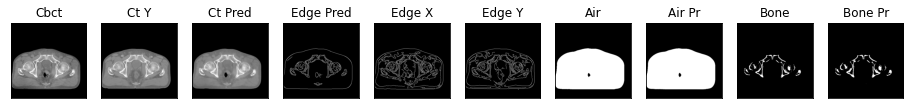

95it [01:08,  1.84it/s]

ssim score = 0.8841214179992676
psnr score = 25.134714126586914
snr score = 16.09834861755371
mae error = 0.020594952628016472
air dice score = 0.9988003071213779
bone dice score = 0.9116384751336577
contour dice score = 0.5116028189659119


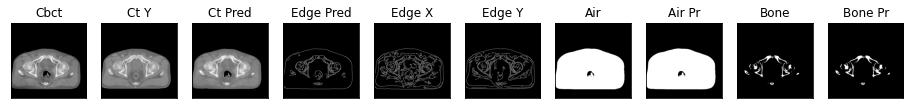

96it [01:08,  1.92it/s]

ssim score = 0.8870223164558411
psnr score = 24.872549057006836
snr score = 15.676422119140625
mae error = 0.02013176679611206
air dice score = 0.9987915505212455
bone dice score = 0.8570602688270406
contour dice score = 0.498374879360199


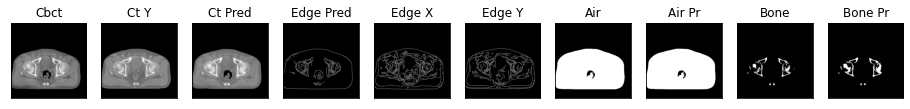

97it [01:09,  1.94it/s]

ssim score = 0.8856223225593567
psnr score = 24.463016510009766
snr score = 15.150466918945312
mae error = 0.020468106493353844
air dice score = 0.9986402533851187
bone dice score = 0.8512518409447533
contour dice score = 0.47199565172195435


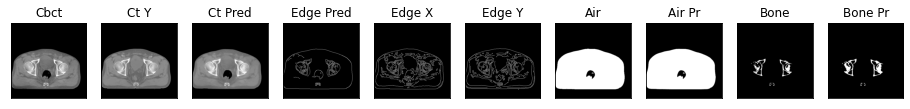

98it [01:09,  1.93it/s]

ssim score = 0.881106972694397
psnr score = 24.362361907958984
snr score = 15.004715919494629
mae error = 0.02056545950472355
air dice score = 0.998803612108102
bone dice score = 0.8846208564534839
contour dice score = 0.5111716389656067


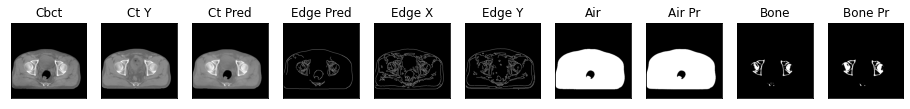

99it [01:10,  1.96it/s]

ssim score = 0.8745623230934143
psnr score = 23.875438690185547
snr score = 14.524467468261719
mae error = 0.021817166358232498
air dice score = 0.9986868023637568
bone dice score = 0.9148311306914122
contour dice score = 0.5019136071205139


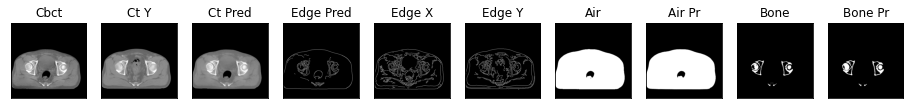

100it [01:10,  1.91it/s]

ssim score = 0.8765720725059509
psnr score = 23.585670471191406
snr score = 14.264801979064941
mae error = 0.022619472816586494
air dice score = 0.9989230073580804
bone dice score = 0.9503628447031878
contour dice score = 0.5202628970146179


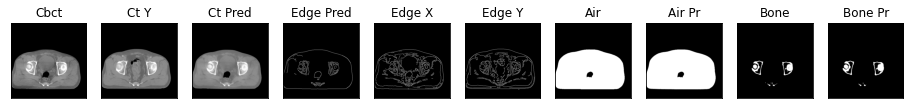

101it [01:11,  1.91it/s]

ssim score = 0.8827726244926453
psnr score = 24.348705291748047
snr score = 14.985250473022461
mae error = 0.020728886127471924
air dice score = 0.9987440795252138
bone dice score = 0.9389835908883386
contour dice score = 0.5350877046585083


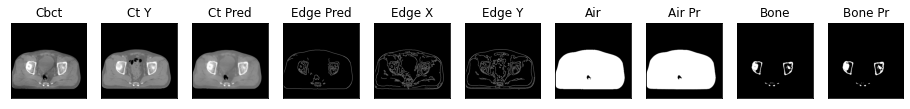

102it [01:11,  1.98it/s]

ssim score = 0.884827196598053
psnr score = 24.6712646484375
snr score = 15.217605590820312
mae error = 0.01966560073196888
air dice score = 0.9987141868055796
bone dice score = 0.8993517570812121
contour dice score = 0.5271232724189758


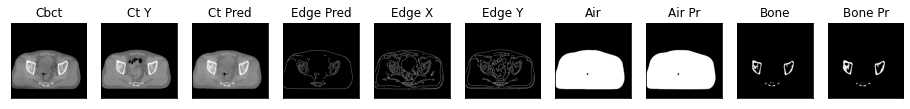

103it [01:12,  1.70it/s]

ssim score = 0.8858748078346252
psnr score = 24.27621078491211
snr score = 14.756827354431152
mae error = 0.01998230814933777
air dice score = 0.9984919054483052
bone dice score = 0.921732799418971
contour dice score = 0.5519516468048096


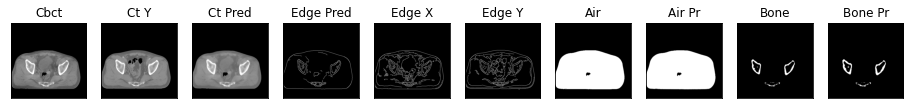

104it [01:13,  1.79it/s]

ssim score = 0.8842968344688416
psnr score = 24.37624168395996
snr score = 14.856553077697754
mae error = 0.019953327253460884
air dice score = 0.998144899312523
bone dice score = 0.9405228758179653
contour dice score = 0.5440528392791748


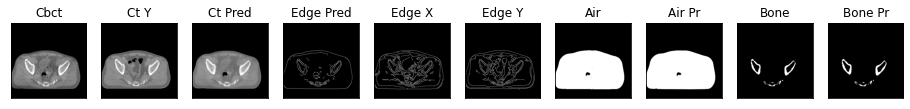

105it [01:13,  1.89it/s]

ssim score = 0.8790857195854187
psnr score = 24.255290985107422
snr score = 14.811769485473633
mae error = 0.021275976672768593
air dice score = 0.9980842587098431
bone dice score = 0.9481256052019902
contour dice score = 0.6147042512893677


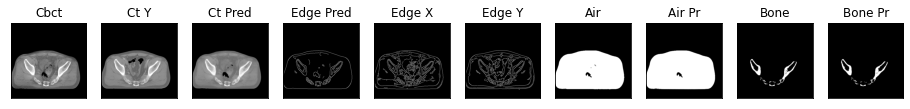

106it [01:14,  1.91it/s]

ssim score = 0.8844038248062134
psnr score = 24.532344818115234
snr score = 15.124405860900879
mae error = 0.020533446222543716
air dice score = 0.9981569965870323
bone dice score = 0.9461266221005882
contour dice score = 0.6147042512893677


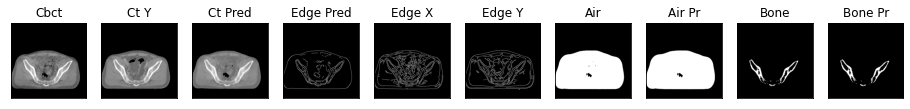

107it [01:14,  1.91it/s]

ssim score = 0.8851597309112549
psnr score = 25.20079803466797
snr score = 15.731162071228027
mae error = 0.01917671039700508
air dice score = 0.9981552190141163
bone dice score = 0.9329082339903949
contour dice score = 0.6063297986984253


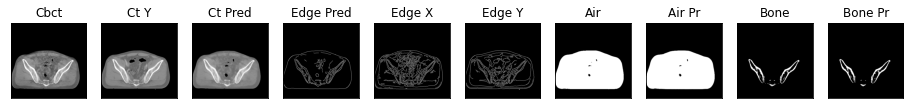

108it [01:15,  1.97it/s]

In [ ]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [ ]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(discriminator)

In [ ]:
discriminator.load_state_dict(checkpoint["dicriminator"])

In [ ]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
# unmasked
eval_epoch(model, discriminator, testloader, device)

In [ ]:
# import torchvision.models as models
# models.vgg16(pretrained=True)